In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import time
from RediCell_cupy import *
from DesignTool import *

In [2]:
d = DesignTool()
d.get_blanket_space([128, 64, 64], spacing=16e-9)
d.add_ecoli_rod(l=2e-6, r=0.4e-6, barrier_type=1, space_type=1, offsety=0)#, offsety=1.6e-7)
d.set_border_wall()
# d.draw3D(exclude_barrier_type=[0], exclude_space_type=[0])


Sides are [128  64  64] with spacing of 1.6e-08 m (3 dimensions).
Overall system sizes are [2.048e-06 1.024e-06 1.024e-06] m
Voxel [64 32 32] has a coordinate of [0.00000000e+00 1.05879118e-22 1.05879118e-22]
Voxel [101, 32, 32] has a coordinate of [5.92000000e-07 1.05879118e-22 1.05879118e-22]
Voxel [27, 32, 32] has a coordinate of [-5.92000000e-07  1.05879118e-22  1.05879118e-22]
Successfully created a E. coli rod


In [3]:
mol_Iex = Molecule('Iex', diffusion_coefficient=1.28e-12, observed_barrier_types=None)
mol_Iin = Molecule('Iin', diffusion_coefficient=1.28e-12, observed_barrier_types=None)
mol_Y = Molecule('Y', diffusion_coefficient=0, observed_barrier_types=None)
mol_YI = Molecule('YI', diffusion_coefficient=0, observed_barrier_types=None)
# mol_B = Molecule('B', diffusion_coefficient=8.15e-14, observed_barrier_types=[1, 2])
# mol_C = Molecule('C', diffusion_coefficient=8.15e-14, observed_barrier_types=[1, 2])
# molset = MoleculeSet([mol_A, mol_B, mol_C])
molset = MoleculeSet([mol_Iex, mol_Iin, mol_Y, mol_YI])

In [4]:
rxset = ReactionSet()
rxset.add_reaction(['Iex'], ['Iin'], 2.33e-3)
rxset.add_reaction(['Iin'], ['Iex'], 2.33e-3)
rxset.add_reaction(['Y', 'Iex'], ['YI'], 3.03e+4)
rxset.add_reaction(['YI'], ['Y', 'Iex'], 1.2e-1)
rxset.add_reaction(['YI'], ['Y', 'Iin'], 1.2e+1)
# rxset.add_reaction(['A', 'B'], ['C'], 1.07e5)
# rxset.add_reaction(['C'], ['A', 'B'], 0.351)

In [33]:
a = RediCell_CuPy(design=d, molecule_types=molset, reaction_set=rxset, t_step=2e-3)

In [34]:
a_supply_matrix = cp.zeros(a.true_sides)
a_supply_matrix[(a.special_space_type == 0) * (a.barrier_type == -1)] = 1
a_supply_matrix[1:-1, 1:-1, [1, 2, -3, -2]] = 1
a_supply_matrix[1:-1, [1, 2, -3, -2], 1:-1] = 1
a_supply_matrix[[1, 2, -3, -2], 1:-1, 1:-1] = 1

a.add_external_conditions(a_supply_matrix, mol_Iex, 5)
a.show_external_conditions()

Maintain 5 micromolar of Iex within a space of 302848 voxels (3736 molecules)


In [35]:
a_supply_matrix.shape

(130, 66, 66)

In [36]:
a.partition()

Reagent list: [[0], [1], [2, 0], [3], [3]]
Action list:
Diffusion of Iex (6 directions)
Diffusion of Iin (6 directions)
Diffusion of Y (6 directions)
Diffusion of YI (6 directions)
Reaction: reagent ['Iex'] -> product ['Iin']
Reaction: reagent ['Iin'] -> product ['Iex']
Reaction: reagent ['Y', 'Iex'] -> product ['YI']
Reaction: reagent ['YI'] -> product ['Y', 'Iex']
Reaction: reagent ['YI'] -> product ['Y', 'Iin']


In [37]:
a.configure_barrier()

In [38]:
a.maintain_external_conditions()

In [39]:
a.mesh[0].shape

(130, 66, 66)

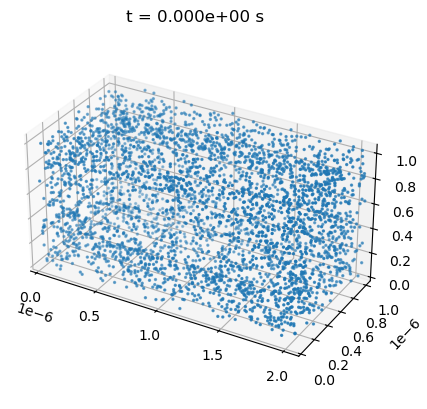

In [40]:
a.plot3D(['Iex'], wall=False)

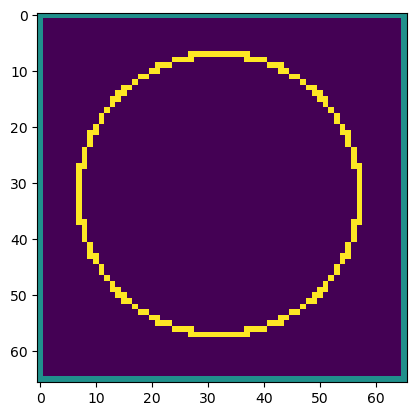

In [41]:
plt.imshow(a.barrier_type[50].get())

In [42]:

# inner = np.where(a.special_space_type == 1)
# num_voxel_inner = len(inner[0])
# print(num_voxel_inner)
# # Change half of that space
# choice = np.random.choice(num_voxel_inner, num_voxel_inner//2, replace=False)
# selection = [x[choice] for x in inner]
# a.barrier_type[selection[0], selection[1], selection[2]] = 2

# place 10000 B
# remaining_inner = np.where((a.special_space_type == 1) * (a.barrier_type == -1))
# num_voxel_remaining_inner = len(remaining_inner[0])
# print(num_voxel_remaining_inner)
# choice = np.random.choice(num_voxel_remaining_inner, 10000, replace=False)
# selection = [x[choice] for x in remaining_inner]
# a.voxel_matrix[1, selection[0], selection[1], selection[2]] = 1

In [43]:
# place 1000 Y where E coli barrier is
barriers = np.where(a.barrier_type.get() == 1)
num_voxel = len(barriers[0])
print(num_voxel)
choice = np.random.choice(num_voxel, 1000, replace=False)
selection = [x[choice] for x in barriers]
a.voxel_matrix[a.mol_to_id['Y'], selection[0], selection[1], selection[2]] = 1

20466


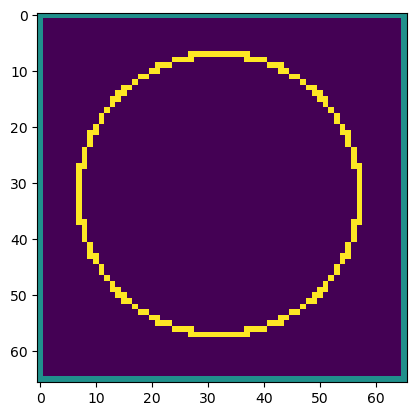

In [44]:
plt.imshow(a.barrier_type[80].get())

In [45]:
a.voxel_matrix[0].sum()

array(3736., dtype=float32)

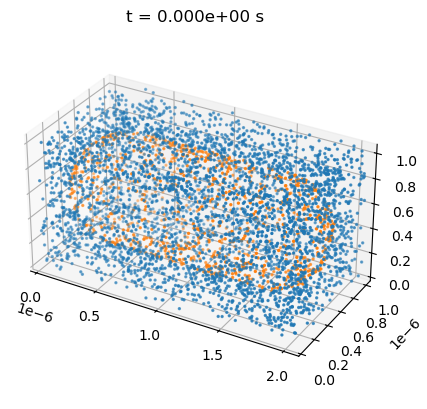

In [46]:
a.plot(['Iex', 'Y'], wall=False)

In [47]:
a.determine_maximum_timestep()

Max time step is 5.00e-05 s (max 1.0 particles in voxel)


array(5.e-05, dtype=float32)

Simulate 2000 steps
20 40 60 80 100 120 140 160 180 200 2.19 s - 10.94 ms / step
220 240 260 280 300 320 340 360 380 400 4.59 s - 11.48 ms / step
420 440 460 480 500 520 540 560 580 600 6.50 s - 10.83 ms / step
620 640 660 680 700 720 740 760 780 800 8.30 s - 10.37 ms / step
820 840 860 880 900 920 940 960 980 1000 10.06 s - 10.06 ms / step
1020 1040 1060 1080 1100 1120 1140 1160 1180 1200 11.91 s - 9.93 ms / step
1220 1240 1260 1280 1300 1320 1340 1360 1380 1400 13.80 s - 9.86 ms / step
1420 1440 1460 1480 1500 1520 1540 1560 1580 1600 15.62 s - 9.76 ms / step
1620 1640 1660 1680 1700 1720 1740 1760 1780 1800 17.49 s - 9.72 ms / step
1820 1840 1860 1880 1900 1920 1940 1960 1980 

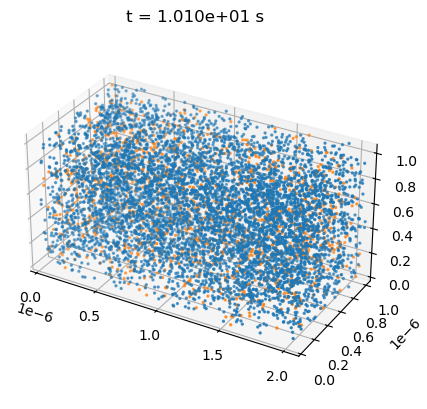

In [23]:
a.simulate(200000, t_step=5e-5, plot_every=None, timing=True)
a.plot(['Iex', 'Iin'], wall=False)

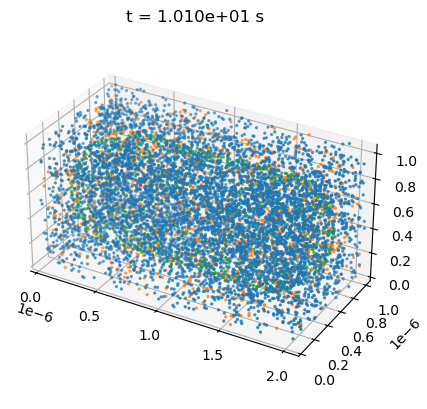

In [28]:
a.plot(['Iex','Iin', 'Y', 'YI'], wall=False)

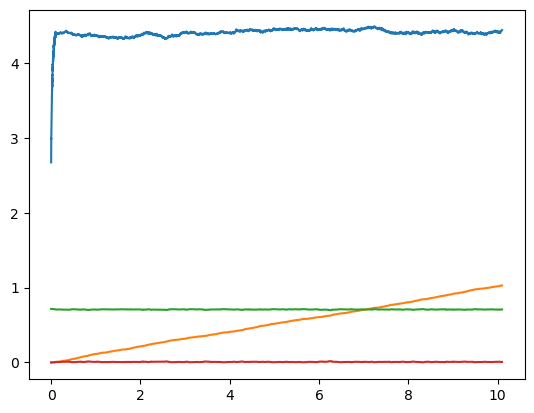

In [27]:
plt.plot(a.t_trace, np.array([x.get() for x in a.conc_trace]) * a.one_per_voxel_equal_um / np.prod(a.voxel_matrix_shape[1:]))
# plt.yticks(range(7))
# plt.yscale('log')

In [32]:
a.one_per_voxel_equal_um * a.voxel_matrix[a.mol_to_id['Iex']].sum() / np.prod(np.array(a.voxel_matrix[0].shape) - 2)

array(4.79964352)

In [54]:
np.prod(np.array(a.voxel_matrix[0].shape) - 2)

4096